## Check for Programmatic variations


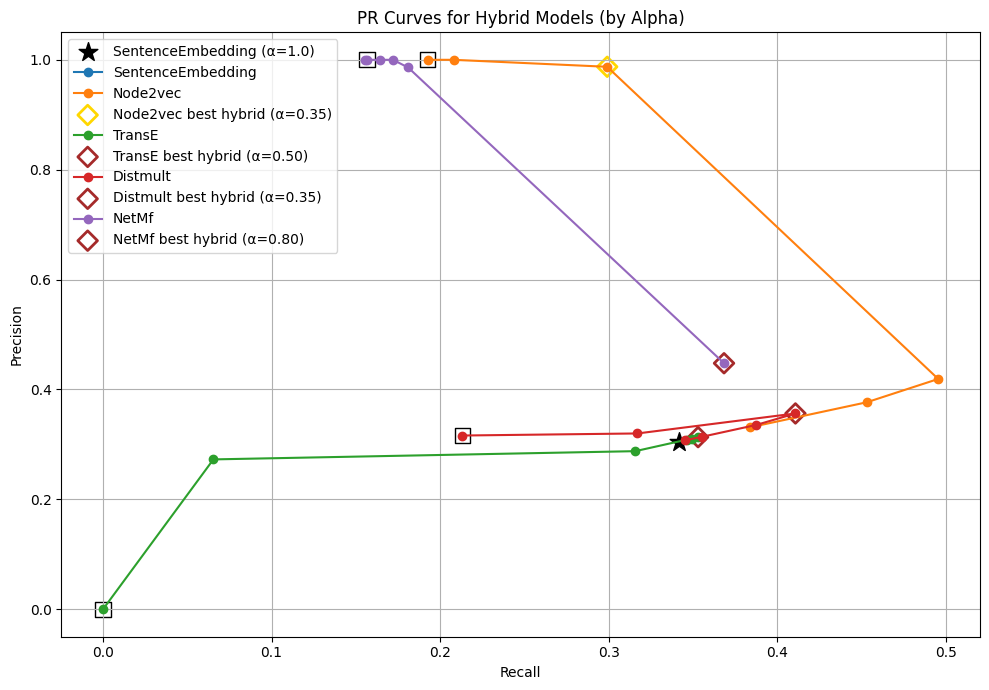

In [20]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import numpy as np
noise = 'high'
# Path and file setup
match_dir = f"matches_struct_{noise}"

golden_standard = pd.read_csv(f'data/test_golden_standard_struct_{noise}.csv')
model_bases = {
    'SentenceEmbedding': "SentenceEmbedding",
    'Node2vec': "HybridNode2vecLow_alpha_",
    'TransE': "HybridTransE_alpha_",
    'Distmult': "HybridDistmult_alpha_",
    'NetMf': "HybridNetMf_alpha_",
}
alpha_values = [0.0, 0.2, 0.35, 0.5, 0.65, 0.8, 1.0]

def extract_uuid(uri):
    return uri.split("/")[-1] if uri else None

def evaluate_matches(match_data, golden_standard):
    identifiers = []
    true_duplicate_pairs = set()
    for match in match_data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        # Always add all pairs to identifiers
        identifiers.append(pair)
        # If this match is an exact/true duplicate, remember the pair
        if match.get('duplication_type') == 'true_duplicate':
            # Use sorted tuple to be order-agnostic
            uuid1, uuid2 = pair['entity1'], pair['entity2']
            true_duplicate_pairs.add(tuple(sorted([uuid1, uuid2])))
    matched_pairs_set = set(
        (pair['entity1'], pair['entity2']) if pair['entity1'] <= pair['entity2'] else (pair['entity2'], pair['entity1'])
        for pair in identifiers
    )
    golden_pairs_set = set(
        (row['original_id'], row['duplicate_id']) if row['original_id'] <= row['duplicate_id'] else (row['duplicate_id'], row['original_id'])
        for _, row in golden_standard.iterrows()
    )
    # Filter out 'true_duplicate' pairs from the false positives
    false_positives = (matched_pairs_set - golden_pairs_set) - true_duplicate_pairs

    TP = len([
        1 for pair in matched_pairs_set if pair in golden_pairs_set
    ])
    FP = len(false_positives)
    FN = len(golden_pairs_set - matched_pairs_set)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return precision, recall

# Prepare to store results
pr_curves = {model: {'precisions': [], 'recalls': [], 'alphas': []} for model in model_bases.keys()}

for model, base in model_bases.items():
    for alpha in alpha_values:
        if alpha == 1.0:
            filename = os.path.join(match_dir, "SentenceEmbedding.json")
        else:
            filename = os.path.join(match_dir, f"{base}{alpha}.json")
        if not os.path.exists(filename):
            continue
        with open(filename, 'r') as f:
            match_data = json.load(f)
        precision, recall = evaluate_matches(match_data, golden_standard)
        pr_curves[model]['precisions'].append(precision)
        pr_curves[model]['recalls'].append(recall)
        pr_curves[model]['alphas'].append(alpha)

# Find the best model and alpha (highest F1 among all models and alphas except alpha=1.0)
best_model = None
best_alpha = None
best_f1 = -1
best_idx = None

for model, curve in pr_curves.items():
    for i, (p, r, a) in enumerate(zip(curve['precisions'], curve['recalls'], curve['alphas'])):
        if a == 1.0:
            continue  # skip SentenceEmbedding
        f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_alpha = a
            best_idx = i

plt.figure(figsize=(10, 7))

# Plot SentenceEmbedding (alpha=1.0) only once
if 'SentenceEmbedding.json' in [os.path.basename(os.path.join(match_dir, "SentenceEmbedding.json"))]:
    se_precision, se_recall = None, None
    for model, curve in pr_curves.items():
        for i, alpha in enumerate(curve['alphas']):
            if alpha == 1.0:
                se_precision = curve['precisions'][i]
                se_recall = curve['recalls'][i]
                break
    if se_precision is not None and se_recall is not None:
        plt.scatter(se_recall, se_precision, marker='*', s=200, color='black', label='SentenceEmbedding (α=1.0)')

# Plot each model's PR curve, highlight best hybrid, and highlight alpha=0.0
for model, curve in pr_curves.items():
    hybrid_recalls = [r for a, r in zip(curve['alphas'], curve['recalls']) if a != 1.0]
    hybrid_precisions = [p for a, p in zip(curve['alphas'], curve['precisions']) if a != 1.0]
    hybrid_alphas = [a for a in curve['alphas'] if a != 1.0]
    plt.plot(hybrid_recalls, hybrid_precisions, marker='o', label=model)
    # Highlight starting point (alpha=0.0)
    if 0.0 in curve['alphas']:
        idx0 = curve['alphas'].index(0.0)
        plt.scatter(curve['recalls'][idx0], curve['precisions'][idx0], marker='s', s=120, color='none', edgecolor='black')
    # Find best hybrid (highest F1)
    best_idx_model = None
    best_f1_model = -1
    for i, (p, r) in enumerate(zip(hybrid_precisions, hybrid_recalls)):
        f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
        if f1 > best_f1_model:
            best_f1_model = f1
            best_idx_model = i
    if best_idx_model is not None:
        marker_color = 'gold' if model == best_model else 'brown'
        plt.scatter(hybrid_recalls[best_idx_model], hybrid_precisions[best_idx_model], marker='D', s=100, edgecolor=marker_color, facecolor='none', linewidths=2, label=f"{model} best hybrid (α={hybrid_alphas[best_idx_model]:.2f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curves for Hybrid Models (by Alpha)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Precision/Recall/F1 per entity type for Sent_upgraded:
                        Precision  Recall      F1
Address                    0.9680  0.9453  0.9565
ContactPoint               1.0000  0.5391  0.7005
Person                     1.0000  0.0354  0.0685
HealthcareOrganization     0.6818  1.0000  0.8108
ServiceDepartment          0.1227  0.4159  0.1895
HealthcarePersonnel        1.0000  0.0354  0.0685

Precision/Recall/F1 per entity type for TransE 0.5:
                        Precision  Recall      F1
Address                    0.9677  0.9375  0.9524
ContactPoint               1.0000  0.5469  0.7071
Person                     1.0000  0.0506  0.0964
HealthcareOrganization     0.5000  1.0000  0.6667
ServiceDepartment          0.1754  0.4425  0.2513
HealthcarePersonnel        1.0000  0.0506  0.0964

Precision/Recall/F1 per entity type for Distmult 0.35:
                        Precision  Recall      F1
Address                    0.9658  0.8828  0.9224
ContactPoint               1.0000  

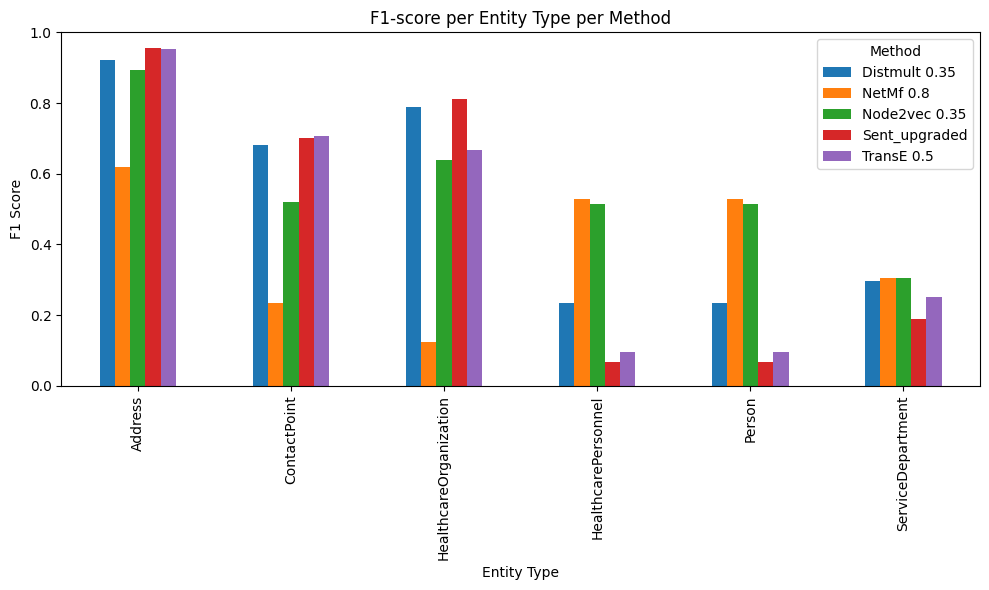

In [21]:
import pandas as pd
import json
import matplotlib.pyplot as plt


# Load the CSV and JSON files
golden_standard = pd.read_csv(f'data/test_golden_standard_struct_{noise}.csv')

#Load both match files
match_files = {
    'Sent_upgraded': json.load(open(f'matches_struct_{noise}/SentenceEmbedding.json', 'r')),
    'TransE 0.5' : json.load(open(f'matches_struct_{noise}/HybridTransE_alpha_0.5.json', 'r')),
    'Distmult 0.35': json.load(open(f'matches_struct_{noise}/HybridDistmult_alpha_0.35.json', 'r')),
    'NetMf 0.8' : json.load(open(f'matches_struct_{noise}/HybridNetMf_alpha_0.8.json', 'r')),
    'Node2vec 0.35': json.load(open(f'matches_struct_{noise}/HybridNode2vecLow_alpha_0.5.json', 'r')),
}


def extract_uuid(uri):
    return uri.split("/")[-1]

precision_recall_summary = {}
percent_summary = {}
entity_type_pr_summary = {}

for match_type, data in match_files.items():
    identifiers = []
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)

    # === PER-ENTITY TYPE PRF computation ===
    prf_per_entity = {}

    # List of entity types in the golden standard
    entity_types = golden_standard['entity_type'].unique()
    # ...existing code...
    for entity_type in entity_types:
        # Filter golden pairs for this entity type
        golden_type_df = golden_standard[golden_standard['entity_type'] == entity_type]
        golden_pairs_set = set(
            (row['original_id'], row['duplicate_id']) if row['original_id'] <= row['duplicate_id'] else (row['duplicate_id'], row['original_id'])
            for _, row in golden_type_df.iterrows()
        )
        valid_ids = set(golden_type_df['original_id']).union(set(golden_type_df['duplicate_id']))
        found_pairs_set = set(
            (pair['entity1'], pair['entity2']) if pair['entity1'] <= pair['entity2'] else (pair['entity2'], pair['entity1'])
            for pair in identifiers
            if pair['entity1'] in valid_ids and pair['entity2'] in valid_ids
        )

        # Find "exact" matches not in golden for this entity type
        exact_not_in_golden = 0
        for match in data:
            # Only consider matches for this entity type
            # (Assumes you have entity_type info in your match or can infer it)
            entity1 = next(e['entity1'] for e in match['entities'] if 'entity1' in e)
            entity2 = next(e['entity2'] for e in match['entities'] if 'entity2' in e)
            uuid1 = extract_uuid(entity1.get("subject"))
            uuid2 = extract_uuid(entity2.get("subject"))
            pair = (uuid1, uuid2) if uuid1 <= uuid2 else (uuid2, uuid1)
            if uuid1 in valid_ids and uuid2 in valid_ids:
                if pair not in golden_pairs_set and match.get("duplication_type") == "exact":
                    exact_not_in_golden += 1

        TP = len(golden_pairs_set & found_pairs_set)
        
        FP = len(found_pairs_set - golden_pairs_set) - exact_not_in_golden
        FN = len(golden_pairs_set - found_pairs_set)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        prf_per_entity[entity_type] = {'Precision': precision, 'Recall': recall, 'F1': F1}
    # ...existing code...
        entity_type_pr_summary[match_type] = prf_per_entity

# Convert results to DataFrames for nice display
entity_prf_dfs = {}
for method, prf_dict in entity_type_pr_summary.items():
    df = pd.DataFrame(prf_dict).T  # entity_type as index
    entity_prf_dfs[method] = df.round(4)

# Display all PRF tables for each method
for method, df in entity_prf_dfs.items():
    print(f"\nPrecision/Recall/F1 per entity type for {method}:")
    print(df)

# If you want a combined table:
combined = []
for method, df in entity_prf_dfs.items():
    df = df.copy()
    df['Method'] = method
    combined.append(df)
combined_df = pd.concat(combined).reset_index().rename(columns={'index':'Entity Type'})
combined_df = combined_df[['Method','Entity Type','Precision','Recall','F1']]
print("\nCombined Precision/Recall/F1 per entity type:")
print(combined_df)

# You can also plot per-entity F1 for all methods
f1_table = combined_df.pivot(index='Entity Type', columns='Method', values='F1')
f1_table.plot(kind='bar', figsize=(10,6))
plt.title('F1-score per Entity Type per Method')
plt.ylabel('F1 Score')
plt.ylim(0,1)
plt.tight_layout()
plt.show()


In [22]:


print("\nTotal number of duplicates found per method:")
for method, data in match_files.items():
    identifiers = []
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = uri.split("/")[-1] if uri else None
        identifiers.append(pair)
    matched_pairs_set = set(
        (pair['entity1'], pair['entity2']) if pair['entity1'] <= pair['entity2'] else (pair['entity2'], pair['entity1'])
        for pair in identifiers
    )
    print(f"{method}: {len(matched_pairs_set)}")




import os
# Store missed matches for each method
missed_matches_by_method = {}

for method, data in match_files.items():
    # Build identifiers for this method
    identifiers = []
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = uri.split("/")[-1] if uri else None
        identifiers.append(pair)

    # Build set of matched pairs
    matched_pairs_set = set(
        (pair['entity1'], pair['entity2']) if pair['entity1'] <= pair['entity2'] else (pair['entity2'], pair['entity1'])
        for pair in identifiers
    )

    # Find matched and missed rows
    matched_rows = golden_standard[
        golden_standard.apply(
            lambda row: ((row['original_id'], row['duplicate_id']) in matched_pairs_set) or
                        ((row['duplicate_id'], row['original_id']) in matched_pairs_set),
            axis=1
        )
    ]
    missed_rows = golden_standard[~golden_standard.index.isin(matched_rows.index)]
    missed_matches_by_method[method] = missed_rows
    print(f"Number of missed matches for {method}: {len(missed_rows)}")
    # Optionally save to CSV for each method
    #os.makedirs("error_analysis", exist_ok=True)
    #missed_rows.to_csv(f"error_analysis/missed_matches_{method.replace(' ', '_')}.csv", index=False)

# # Build set of matched pairs from identifiers
# matched_pairs_set = set(
#     (pair['entity1'], pair['entity2']) if pair['entity1'] <= pair['entity2'] else (pair['entity2'], pair['entity1'])
#     for pair in identifiers
# )

# # Find golden_standard rows whose (original_id, duplicate_id) or (duplicate_id, original_id) are in matched_pairs_set
# matched_rows = golden_standard[
#     golden_standard.apply(
#         lambda row: ((row['original_id'], row['duplicate_id']) in matched_pairs_set) or
#                     ((row['duplicate_id'], row['original_id']) in matched_pairs_set),
#         axis=1
#     )
# ]


# # Find all golden standard matches that were NOT found by the last algorithm run in the loop
# missed_rows = golden_standard[~golden_standard.index.isin(matched_rows.index)]

# print(f"Number of missed matches: {len(missed_rows)}")
# missed_rows.head()  # Show a sample
# # Save missed matches to CSV for error analysis
# os.makedirs("error_analysis", exist_ok=True)
# missed_rows.to_csv("error_analysis/missed_matches.csv", index=False)


Total number of duplicates found per method:
Sent_upgraded: 873
TransE 0.5: 878
Distmult 0.35: 898
NetMf 0.8: 641
Node2vec 0.35: 921
Number of missed matches for Sent_upgraded: 894
Number of missed matches for TransE 0.5: 879
Number of missed matches for Distmult 0.35: 802
Number of missed matches for NetMf 0.8: 745
Number of missed matches for Node2vec 0.35: 651


In [13]:
missed_rows 

,entity_type,original_id,duplicate_id,variation_type,field_name
10,Address,4598244b-f0bd-4405-a50d-d400a27ee80d,a33e3982-72b1-44ae-be4c-8d1f3d01fe38,omission,text
19,Address,853a9135-3ee2-451b-be88-c93319db1d7b,cd81a6dd-ac43-4ee7-8efa-b705a624f6ab,omission,text
21,Address,a4b0c73b-f74e-41a1-a2e5-b72606b9370b,a7d5abf4-985a-4a57-9a85-825d4ebd4adc,omission,text
26,Address,21ab9e3d-fdf4-4f09-bd87-d79311705ee3,8c5ba2dc-d55e-4dcb-8d57-43de643211d6,omission,text
29,Address,15f82b2f-bc89-4faf-8cf4-627782dcf736,68447eb9-d9a9-47aa-8955-c8fc84633d07,omission,text
...,...,...,...,...,...
1166,HealthcarePersonnel,1386a0eb-1f6c-45c8-9703-5b6f42308db6,be8aaa39-1549-4c6b-b006-16f9a7d42470,omission,jobTitle
1167,HealthcarePersonnel,a27d4962-37aa-43d0-b217-4c8f412485a8,8178abc9-f53b-49f0-b15b-d6fd1694a11b,omission,jobTitle
1168,HealthcarePersonnel,4def7440-71b7-4a85-8d1d-86b64206e969,55a413b8-c152-4d4e-b44e-5ff62cc07a2a,omission,jobTitle
1171,HealthcarePersonnel,caabf1a2-e31e-4d64-9f64-d38fbeeab4a5,0e43428f-5699-4b91-a205-238c92f1d606,omission,jobTitle
